# Resonator benchmark (COMSOL)

Run this notebook in your browser using [Binder](https://mybinder.org/v2/gh/flexcompute-readthedocs/tidy3d-docs/readthedocs?labpath=docs%2Fsource%2Fnotebooks%2FHighQ_Si.ipynb).

In this example, we reproduce the findings of Zhang et al. (2018), which is linked [here](https://www.osapublishing.org/ol/abstract.cfm?uri=ol-43-8-1842).

This notebook was originally developed and written by Romil Audhkhasi (USC). 

The paper investigates the resonances of silicon structures by measuring their transmission spectrum under varying geometric parameters.

The paper uses a finite element solver (COMSOL), which matches the result from Tidy3D.

<img src="img/Si_struct.png" alt="diagram" width="500"/>

(Citation: Opt. Lett. 43, 1842-1845 (2018).  With permission from the Optical Society)

To do this calculation, we use a broadband pulse and frequency monitor to measure the flux on the opposite side of the structure.

In [1]:
# standard python imports
import numpy as np
import matplotlib.pyplot as plt

# tidy3D import
import tidy3d as td
from tidy3d import web

## Set Up Simulation

In [2]:
nm = 1e-3

# define the frequencies we want to measure
Nfreq = 1000
wavelengths = nm * np.linspace(1050, 1400, Nfreq)
freqs = td.constants.C_0 / wavelengths

# define the frequency center and width of our pulse
freq0 = freqs[len(freqs)//2]
freqw = freqs[0] - freqs[-1]

# Define material properties
n_SiO2 = 1.46
n_Si = 3.52
SiO2 = td.Medium(permittivity=n_SiO2**2)
Si = td.Medium(permittivity=n_Si**2)

In [3]:
# space between resonators and source
spc = 1.5

# geometric parameters
Px = Py = P = 650 * nm  # periodicity in x and y
t = 260 * nm            # thickness of silcon
g = 80 * nm             # gap size
L = 480 * nm            # length in x
w_sum = 400 * nm        # sum of lengths in y

# resolution (should be commensurate with periodicity)
dl = P / 32

# computes widths in y (w1 and w2) given the difference in lengths in y and the sum of lengths
def calc_ws(delta):
    """ delta is a tunable parameter used to break symmetry.
        w_sum = w1 + w2
        delta = w1 - w2
        w_sum + delta = 2 * w1
    """
    w1 = (w_sum + delta) / 2
    w2 = w_sum - w1
    return w1, w2

In [4]:
# total size in z and [x,y,z]
Lz = spc + t + t + spc
sim_size = [Px, Py, Lz]

# sio2 substrate
substrate = td.Structure(
    geometry=td.Box(
        center=[0, 0, -Lz/2],
        size=[td.inf, td.inf, 2*(spc+t)],
    ),
    medium=SiO2,
    name='substrate'
)

# creates a list of structures given a value of 'delta'
def geometry(delta):
    w1, w2 = calc_ws(delta)
    center_y = (w1 - w2) / 2.0

    cell1 = td.Structure(
        geometry=td.Box(
            center=[0, center_y + (g + w1)/2., t/2.],
            size=[L, w1, t],
        ),
        medium=Si,
        name='cell1'
    )

    cell2 = td.Structure(
        geometry=td.Box(
            center=[0, center_y - (g + w2)/2., t/2.],
            size=[L, w2, t],
        ),
        medium=Si,
        name='cell2'
    )

    return [substrate, cell1, cell2]


In [5]:
# time dependence of source
gaussian = td.GaussianPulse(freq0=freq0, fwidth=freqw)

# plane wave source
source = td.PlaneWave(
            source_time=gaussian,
            direction='-',
            size=(td.inf, td.inf, 0),
            center=(0,0,Lz/2 - spc + 2*dl),
            pol_angle=0.0)

# Simulation run time.  Note you need to run a long time to calculate high Q resonances.
run_time = 7e-12

In [6]:
# monitor fields on other side of structure (substrate side) at range of frequencies
monitor = td.FluxMonitor(
        center=[0., 0., -Lz/2 + spc - 2 * dl],
        size=[td.inf, td.inf, 0],
        freqs=freqs,
        name='flux')

## Define Case Studies

Here we define the three simulations to run

- With no resonators (normalization)
- With symmetric (delta = 0) resonators
- With asymmetric (delta != 0) resonators


In [7]:
grid_spec = td.GridSpec(
    grid_x = td.UniformGrid(dl=dl),
    grid_y = td.UniformGrid(dl=dl),
    grid_z = td.AutoGrid(min_steps_per_wvl=32)
)

# normalizing run (no Si) to get baseline transmission vs freq
# can be run for shorter time as there are no resonances
sim_empty = td.Simulation(size=sim_size,
                    grid_spec=grid_spec,
                    structures=[substrate],
                    sources=[source],
                    monitors=[monitor],
                    run_time=run_time/10,
                    boundary_spec=td.BoundarySpec.pml(z=True))

# run with delta = 0
sim_d0 = td.Simulation(size=sim_size,
                    grid_spec = grid_spec,
                    structures=geometry(0),
                    sources=[source],
                    monitors=[monitor],
                    run_time=run_time,
                    boundary_spec=td.BoundarySpec.pml(z=True))

# run with delta = 20nm
sim_d20 = td.Simulation(size=sim_size,
                    grid_spec = grid_spec,
                    structures=geometry(20 * nm),
                    sources=[source],
                    monitors=[monitor],
                    run_time=run_time,
                    boundary_spec=td.BoundarySpec.pml(z=True))

[09:39:22] INFO     Auto meshing using wavelength 1.2252 defined from sources.                     ]8;id=843838;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/grid/grid_spec.py\grid_spec.py]8;;\:]8;id=887895;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/grid/grid_spec.py#473\473]8;;\

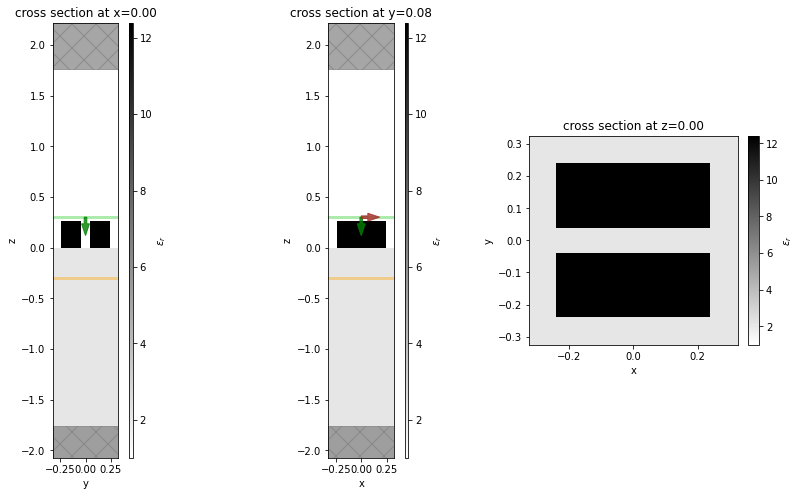

In [8]:
# Structure visualization in various planes

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 8))
sim_d0.plot_eps(x=0, ax=ax1)
sim_d0.plot_eps(y=g, ax=ax2)
sim_d0.plot_eps(z=0, ax=ax3)
plt.show()

## Run Simulations

In [9]:
batch = web.Batch(
    simulations={
        'normalization': sim_empty,
        'Si-resonator-delta-0': sim_d0,
        'Si-resonator-delta-20': sim_d20,
    }
)

results = batch.run(path_dir='data')

normalization: status = success             ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00
Si-resonator-delta-0: status = success      ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00
Si-resonator-delta-20: status = postprocess ━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━  71% -:--:--

[09:40:52] Batch complete.                                                                         ]8;id=798171;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py\container.py]8;;\:]8;id=358152;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py#374\374]8;;\

## Get Results and Plot

In [10]:
batch_data = batch.load(path_dir='data')
flux_norm = batch_data['normalization']['flux'].flux
trans_g0 = batch_data['Si-resonator-delta-0']['flux'].flux / flux_norm
trans_g20 = batch_data['Si-resonator-delta-20']['flux'].flux / flux_norm

↓ monitor_data.hdf5 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0% • 0.0/111.8 kB • ? • -:--:--

[09:41:01] INFO     loading SimulationData from data/d4d95507-0137-44b5-87d5-37ba427c5db3.hdf5        ]8;id=755788;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=690396;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#397\397]8;;\

[09:41:02] WARNING  Simulation final field decay value of 0.00206 is greater than the simulation      ]8;id=52294;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=847331;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#403\403]8;;\
                    shutoff threshold of 1e-05. Consider simulation again with large run_time                      
                    duration for more accurate results.                                                            

           INFO     Auto meshing using wavelength 1.2252 defined from sources.                     ]8;id=428699;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/grid/grid_spec.py\grid_spec.py]8;;\:]8;id=484454;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/grid/grid_spec.py#473\473]8;;\

The normalizing run computes the transmitted flux for an air -> SiO2 interface, which is just below unity due to some reflection.

While not technically necessary for this example, since this transmission can be computed analytically, it is often a good idea to run a normalizing run so you can accurately measure the *change* in output when the structure is added.  For example, for multilayer structures, the normalizing run displays frequency dependence, which would make it prudent to include in the calculation.

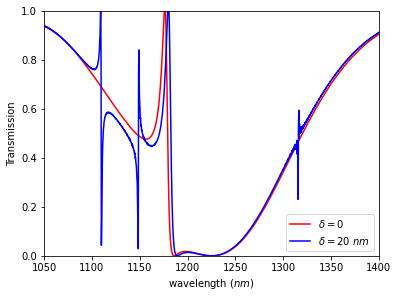

In [11]:
# plot transmission, compare to paper results, look similar
fig, ax = plt.subplots(1, 1, figsize=(6, 4.5))
wavelengths_nm = td.C_0 / trans_g0.f / nm
plt.plot(wavelengths_nm, trans_g0.values, color='red', label='$\delta=0$')
plt.plot(wavelengths_nm, trans_g20.values, color='blue', label='$\delta=20~nm$')
plt.xlabel('wavelength ($nm$)')
plt.ylabel('Transmission')
plt.xlim([1050, 1400])
plt.ylim([0, 1])
plt.legend()
plt.show()

## Results Comparison

Compare this plot to published results computed using COMSOL (FEM):

<img src="img/Si_plot.png" alt="diagram" width="400"/>

(Citation: Opt. Lett. 43, 1842-1845 (2018).  With permission from the Optical Society)